## В этом блокноте я разбираюсь, как работает функция Realign в SPM.

* [Подготовка](#Подготовка)
* [Зачем нужна функция Realign?](#Зачем-нужна-функция-Realign?)
* [Realign в режиме `estimate`](#Realign-в-режиме-estimate)
* [Realign в режиме `estimate and reslice`](#Realign-в-режиме-estimate-and-reslice)

### Подготовка

Импортирую библиотеки и указываю путь к Матлабу и SPM. 

In [2]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
from nipype.interfaces import spm
matlab_cmd = '/opt/spm12-r7219/run_spm12.sh /opt/matlabmcr-2010a/v713/ script'
spm.SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)

201027-19:00:48,810 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


Конвертирую сырые DICOM-файлы из папки `dicom_files` в NIfTI-объемы, которые будут лежать в папке `raw_nii_files`. 

In [4]:
dicom_dir = 'dicom_files'
dicom_files = os.listdir(dicom_dir)

dicom_import = spm.DicomImport()
dicom_import.inputs.in_files = ['dicom_files/' + i for i in dicom_files]
dicom_import.inputs.output_dir = 'raw_nii_files'
dicom_import.run()

И отображаю один из срезов. 

In [5]:
raw_nii_files = [i for i in os.listdir('raw_nii_files')[10:] if i.endswith('nii')] 
fmri = nib.load('raw_nii_files/' + raw_nii_files[0])
fmri_array = fmri.get_fdata()

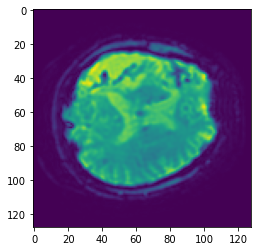

In [6]:
plt.imshow(fmri_array[:,:,20])

### Зачем нужна функция Realign?

Она нужна на случай, если пациент будет не лежать спокойно и ровно во время получения серии данных фМРТ, а будет крутить головой. 

Давайте посмотрим, как пациент двигал головой. Возьмем один и тот же слой с каждого собранного объема (между ними по 2.5 секунды). 

In [7]:
import imageio

In [8]:
%%capture 
#Вылетают требовния сконвертировать данные в uint8, отключаю их. Все и так работает. 
images = []
for file in raw_nii_files:
    fmri = nib.load('raw_nii_files/' + file)
    fmri_array = fmri.get_fdata()
    images.append(fmri_array[:,:,20])
    
imageio.mimwrite('animation.gif', images, duration=0.1)

<img src="animation.gif" width="250">

Не сказать, чтобы он прямо вертел головой, но небольшие движения все равно есть. Realign умеет их убирать. 

Перед тем, как ее использовать, давайте посмотрим на состояние матрицы affine (она показывает, как был подкручен FOV относительно осей томографа, а также отражает его смещение относительно изоцентра). Точнее, посмотрим на состояние одного из рядов этой матрицы. Он одинаковый у всех NIfTI-объемов. Как лаборант выставил FOV, такой он и был в течение всей серии, это логично. 

In [10]:
affine_row = np.array([0,0,0,0])
for each in raw_nii_files:
    fmri = nib.load('raw_nii_files/' + each)
    affine_row = np.vstack([affine_row, fmri.affine[1]])
    print(fmri.affine[1])

[-2.99986601e-02  1.69627619e+00 -6.23390198e-01 -7.18620682e+01]
[-2.99986601e-02  1.69627619e+00 -6.23390198e-01 -7.18620682e+01]
[-2.99986601e-02  1.69627619e+00 -6.23390198e-01 -7.18620682e+01]
[-2.99986601e-02  1.69627619e+00 -6.23390198e-01 -7.18620682e+01]
[-2.99986601e-02  1.69627619e+00 -6.23390198e-01 -7.18620682e+01]
[-2.99986601e-02  1.69627619e+00 -6.23390198e-01 -7.18620682e+01]
[-2.99986601e-02  1.69627619e+00 -6.23390198e-01 -7.18620682e+01]
[-2.99986601e-02  1.69627619e+00 -6.23390198e-01 -7.18620682e+01]
[-2.99986601e-02  1.69627619e+00 -6.23390198e-01 -7.18620682e+01]
[-2.99986601e-02  1.69627619e+00 -6.23390198e-01 -7.18620682e+01]
[-2.99986601e-02  1.69627619e+00 -6.23390198e-01 -7.18620682e+01]
[-2.99986601e-02  1.69627619e+00 -6.23390198e-01 -7.18620682e+01]
[-2.99986601e-02  1.69627619e+00 -6.23390198e-01 -7.18620682e+01]
[-2.99986601e-02  1.69627619e+00 -6.23390198e-01 -7.18620682e+01]
[-2.99986601e-02  1.69627619e+00 -6.23390198e-01 -7.18620682e+01]
[-2.999866

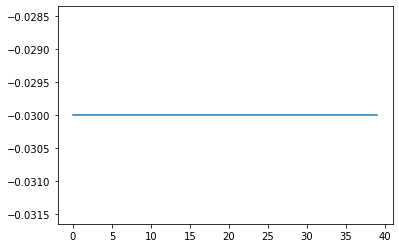

In [11]:
plt.plot(affine_row[1:,0])

### Realign в режиме `estimate`

Realign в режиме `estimate` не вносит никаких изменений в сам воксельный массив, а только подправляет метаданные файлов (`header`). В частности, изменяет матрицу affine, указывая, как должен быть выставлен FOV каждого объема, чтобы эти объемы были ориентированы идентично. 

In [24]:
realign = spm.Realign()
realign.inputs.in_files = ['raw_nii_files/' + i for i in raw_nii_files]
realign.inputs.jobtype = 'estimate'
realign.run()

Посмотрим, как изменилась та строка из affine, которую мы выводили до этого. 

In [13]:
affine_row = np.array([0,0,0,0])
for each in raw_nii_files:
    fmri = nib.load('raw_nii_files/' + each)
    affine_row = np.vstack([affine_row, fmri.affine[2]])
    print(fmri.affine[2])

[-7.33280182e-03  3.60328555e-01  2.93451691e+00 -3.45279236e+01]
[-6.38139248e-03  3.58877420e-01  2.93505549e+00 -3.45062790e+01]
[-4.71484661e-03  3.56449127e-01  2.93595028e+00 -3.45338440e+01]
[-3.39448452e-03  3.54990423e-01  2.93648434e+00 -3.46098862e+01]
[-3.43823433e-03  3.55363131e-01  2.93634939e+00 -3.46207008e+01]
[-2.96020508e-03  3.54405761e-01  2.93669701e+00 -3.46062965e+01]
[-2.69436836e-03  3.54194641e-01  2.93677402e+00 -3.46145401e+01]
[-3.24940681e-03  3.58598053e-01  2.93517303e+00 -3.47817116e+01]
[-3.75342369e-03  3.60441029e-01  2.93449593e+00 -3.48516579e+01]
[-4.70089912e-03  3.61845016e-01  2.93397474e+00 -3.48722496e+01]
[-4.49705124e-03  3.60641301e-01  2.93441916e+00 -3.48273582e+01]
[-4.68373299e-03  3.60801458e-01  2.93435931e+00 -3.48644066e+01]
[-4.80604172e-03  3.62644792e-01  2.93367863e+00 -3.49582748e+01]
[-4.98569012e-03  3.62739325e-01  2.93364286e+00 -3.49265938e+01]
[-4.34803963e-03  3.62111211e-01  2.93387794e+00 -3.49252892e+01]
[-4.156470

Ну, она изменилась довольно сильно. Надо заметить, что в данном случае выравнивание произошло не по отношению к самому первому объему, а к среднему арифметическому всех объемов, так что affine оказалась подправлена у всех объемов, включая первый. 

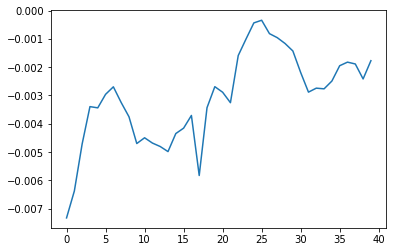

In [14]:
plt.plot(affine_row[1:,0])

Тем не менее, как я уже сказал, воксельный массив остался неизменным, поэтому если сделать ту же анимацию одного и того же слоя с каждого объема, ротация головы по-прежнему заметна. 

In [15]:
%%capture 
#Вылетают требовния сконвертировать данные в uint8, отключаю их. Все и так работает. 
images = []
for file in raw_nii_files:
    fmri = nib.load('raw_nii_files/' + file)
    fmri_array = fmri.get_fdata()
    images.append(fmri_array[:,:,20])
    
imageio.mimwrite('animation_align_est.gif', images, duration=0.1)

<img src="animation_align_est.gif" width="250">

### Realign в режиме `estimate and reslice`

В этом режиме SPM оценивает, как пациент повернул голову, и сразу исправляет FOV, чтобы это вращение скомпенсировать. 

In [17]:
realign = spm.Realign()
realign.inputs.in_files = ['raw_nii_files/' + i for i in raw_nii_files]
realign.run()

In [18]:
aligned_nii_files = [i for i in os.listdir('raw_nii_files')[10:] if i.startswith('r') and i.endswith('nii')] 

In [19]:
%%capture 
#Вылетают требовния сконвертировать данные в uint8, отключаю их. Все и так работает. 
images = []
for file in aligned_nii_files:
    fmri = nib.load('raw_nii_files/' + file)
    fmri_array = fmri.get_fdata()
    images.append(fmri_array[:,:,20])
    
imageio.mimwrite('animation_align_estwrite.gif', images, duration=0.1)

В результате, если сделать гифку, видно, что вращение исправлено, голова лежит ровно и совсем не двигается. 

Давайте сразу три гифки покажу, первая на сырых данных, вторая в режиме estimate, третья в режиме estimate and reslice. 

<img src="animation.gif" width="250">
<img src="animation_align_est.gif" width="250">
<img src="animation_align_estwrite.gif" width="250">

Матрица affine у всех объемов стала как у самого первого -- видимо, по умолчанию SPM выравнивает по первому. Впрочем, это регулируется гиперпараметрами. 

In [26]:
affine_row = np.array([0,0,0,0])
for each in aligned_nii_files:
    fmri = nib.load('raw_nii_files/' + each)
    affine_row = np.vstack([affine_row, fmri.affine[2]])
    print(fmri.affine[2])

[-7.33280182e-03  3.60328555e-01  2.93451691e+00 -3.45279236e+01]
[-7.33280182e-03  3.60328555e-01  2.93451691e+00 -3.45279236e+01]
[-7.33280182e-03  3.60328555e-01  2.93451691e+00 -3.45279236e+01]
[-7.33280182e-03  3.60328555e-01  2.93451691e+00 -3.45279236e+01]
[-7.33280182e-03  3.60328555e-01  2.93451691e+00 -3.45279236e+01]
[-7.33280182e-03  3.60328555e-01  2.93451691e+00 -3.45279236e+01]
[-7.33280182e-03  3.60328555e-01  2.93451691e+00 -3.45279236e+01]
[-7.33280182e-03  3.60328555e-01  2.93451691e+00 -3.45279236e+01]
[-7.33280182e-03  3.60328555e-01  2.93451691e+00 -3.45279236e+01]
[-7.33280182e-03  3.60328555e-01  2.93451691e+00 -3.45279236e+01]
[-7.33280182e-03  3.60328555e-01  2.93451691e+00 -3.45279236e+01]
[-7.33280182e-03  3.60328555e-01  2.93451691e+00 -3.45279236e+01]
[-7.33280182e-03  3.60328555e-01  2.93451691e+00 -3.45279236e+01]
[-7.33280182e-03  3.60328555e-01  2.93451691e+00 -3.45279236e+01]
[-7.33280182e-03  3.60328555e-01  2.93451691e+00 -3.45279236e+01]
[-7.332801